In [4]:
import numpy as np  
from skimage.color import rgb2gray  
import matplotlib.pyplot as plt  
import cv2
np.set_printoptions(threshold=np.nan)
import sklearn.preprocessing

In [5]:
def get_harris_position(img,K = 0.04,threshold = 0.01):
    img = rgb2gray(img)
    height, width = np.shape(img)
    grandfx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)
    grandfy = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)  # compute the X direction and Y direction gradient 
    
    Ix2 = grandfx**2
    Iy2 = grandfy**2
    Ixy = grandfx*grandfy
    
    Ix2 = grandfx**2
    Iy2 = grandfy**2
    Ixy = grandfx*grandfy
    
    A = cv2.GaussianBlur(Ix2,(5,5),2)  # eliminate the noises
    B = cv2.GaussianBlur(Iy2,(5,5),2) 
    C = cv2.GaussianBlur(Ixy,(5,5),2)
    
    M = [np.array([[A[i, j], C[i, j]], #compute M
               [C[i, j], B[i, j]]]) for i in range(height) for j in range(width)]

    D, T = list(map(np.linalg.det, M)), list(map(np.trace, M))  #computer det(M) and trace(M)
    R = np.array([d-k*t**2 for d, t in zip(D, T)]) #computer R
    R_max = np.max(R)
    R = R.reshape(height, width)
    
    count = 0
    corners = []
    for i in range(1,height-1):  #computer whether Rij is the maximum value in a certain area and it is greater than the threshold*R_max
        for j in range(1,width-1):
            if R[i, j] > R_max*threshold:
                if R[i, j] == np.max(R[i-1:i+2, j-1:j+2]):
                    corners.append([i,j])
                    count += 1             
    corners = np.array(corners) #position of corners
    return corners

In [21]:
def show_corner(img,corners,K,threshold):
    fig, ax = plt.subplots()  # show corners
    ax.imshow(img, cmap=plt.cm.gray)
    ax.plot(corners[:, 1], corners[:, 0], '.b', markersize=8)
    plt.title('k = {}, threshold = {}'.format(K,threshold))
    plt.show()

In [63]:
# this function is to get keypoints and descriptors according to the given corners
# and assign them into cv2.KeyPoint for final drawing pictures
def get_patch(img, corners, patch_size):
    # initialize keypoints and descriptors
    keypoints, descriptors = [], []
    
    # take half of patchsize
    halfpatch = int(patch_size/2)
    
    for x, y in corners:
        # imgs are pedded, therefore x and y coordinates need to be changed according to the pedding pixels.
        x += pedding_pixels
        y += pedding_pixels
        
        keypoints.append(cv2.KeyPoint(y, x, patch_size))
        
        # descriptors are squares centered as x and y, halfpatch to each side.
        desc = img[x - halfpatch : x + halfpatch + 1,
                   y - halfpatch : y + halfpatch + 1]
        
        # normalization of descriptors
        desc = sklearn.preprocessing.normalize(desc)
        descriptors.append(desc.ravel())
        
    return np.array(keypoints), np.array(descriptors)

In [124]:
def ssd_match(des1, des2):
    # initialize matches_origin , matches after filtered, and statistic values as a dictionary
    matches_origin = []
    matches = []
    stats = {'matched_origin': 0, 'matched': 0,'std': 0, 'mean': 0}
    
    # loop through each patch in descriptors1
    for index, value in enumerate(des1):
        # Calculate SSD between descriptor[index] and all descriptors in des2
        ssd = np.sqrt(((value - des2) ** 2).sum(axis=1))
        # Get first best and second best indices
        first_index, second_index = np.argsort(ssd)[:2]
        # Get first best and second best SSD values
        first_value, second_value = ssd[first_index], ssd[second_index]
        
        # Check if ratio is at 'r'
        if first_value / (float(second_value) + 10e-10) < r:
            # assign original match into a cv2.DMatch datastructure
            matches_origin.append(cv2.DMatch(index, first_index, first_value))
            # the number of matched_origin is added by one
            stats['matched_origin'] += 1
            # find the best match from des2[first_index] to all points in des1 by a reverse testing 
            ssd_re = np.sqrt(((des2[first_index] - des1) ** 2).sum(axis=1))
            index_re = np.argsort(ssd_re)[0]
            # Check whether the indices of the first_matches are the same
            # if the indices are the same, indicating they are the matched
            if index == index_re:
                matches.append(cv2.DMatch(index, first_index, first_value))
                # the number of matched is added by one
                stats['matched'] += 1
    # the SSDs between matches
    matched = [eachm.distance for eachm in matches]
    # calculate the stand diviation
    stats['std'] = np.std(matched)
    # calculate the mean 
    stats['mean'] = np.mean(matched)
    return matches_origin, matches, stats

In [125]:
def ssdstat(matches,stats):
    print('number of original matches:',stats['matched_origin'],'\n')
    print('number of matches:',stats['matched'],'\n')
    print('std of matches:', stats['std'],'\n')
    print('mean of matches:', stats['mean'],'\n')

patch_size =  5
r =  0.7
pedding_pixels =  30
k = 0.04
threshold = 0.05
corners1 247
corners2 249


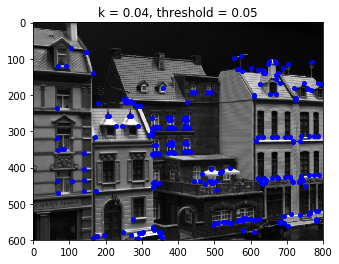

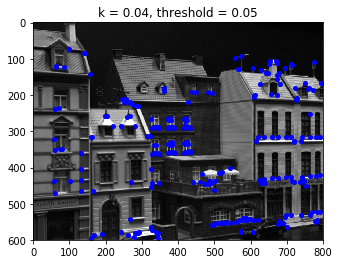

In [134]:
# main programme
patch_size = 5 #(the patch size, between 3-31, odd)
print("patch_size = ",patch_size)

#(the ratio between best match and the second match)
r = 0.7
# for r in [0.95,0.9,0.85,0.8,0.75,0.7,0.65,0.6]:
print("r = ",r)

pedding_pixels = 30
print('pedding_pixels = ',pedding_pixels)

K = 0.04
print('k = {}'.format(K))

threshold = 0.05
print('threshold = {}'.format(threshold))

filename1 = 'Img001_diffuse_smallgray.png'
filename2 = 'Img002_diffuse_smallgray.png'
img1 = cv2.imread(filename1,0)
img2 = cv2.imread(filename2,0)

# part 1 
corners1 = get_harris_position(img1,threshold = threshold)
corners2 = get_harris_position(img2,threshold = threshold)
print("corners1",len(corners1))
print("corners2",len(corners2))
show_corner(img1,corners1,K,threshold)
show_corner(img2,corners2,K,threshold)


In [136]:
# part 2
replicate_img1 = cv2.copyMakeBorder(img1,pedding_pixels,pedding_pixels,pedding_pixels,pedding_pixels,cv2.BORDER_REPLICATE)
replicate_img2 = cv2.copyMakeBorder(img2,pedding_pixels,pedding_pixels,pedding_pixels,pedding_pixels,cv2.BORDER_REPLICATE)

kps1, descriptors1 = get_patch(replicate_img1,corners1,patch_size)
kps2, descriptors2 = get_patch(replicate_img2,corners2,patch_size)

matches_origin12,matches12,stats12 = ssd_match(descriptors1,descriptors2)
matches_origin21,matches21,stats21 = ssd_match(descriptors2,descriptors1)

In [137]:
total = ssdstat(matches12,stats12)

number of original matches: 85 

number of matches: 76 

std of matches: 0.06304419855350309 

mean of matches: 0.11888473397611003 



In [138]:
total = ssdstat(matches21,stats21)

number of original matches: 91 

number of matches: 81 

std of matches: 0.06758802016968472 

mean of matches: 0.12963336793544852 



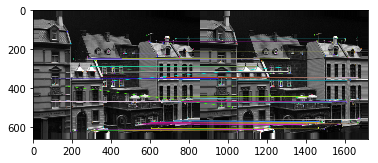

In [139]:
plt.cla()
img12 = cv2.drawMatches(replicate_img1, kps1, replicate_img2, kps2, matches12, None)
plt.imshow(img12,cmap = "gray")
plt.show()

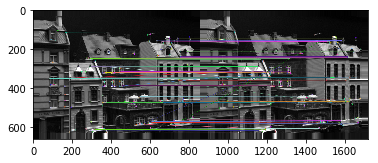

In [140]:
plt.cla()
img12 = cv2.drawMatches(replicate_img2, kps2, replicate_img1, kps1, matches21, None)
plt.imshow(img12,cmap = "gray")
plt.show()